In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer

/opt/anaconda3/envs/UncertaintyGeoXAI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('../data/china_sites_2018_05_PM2.5_all.csv')

In [3]:
data.head()

,id,name,city,lon,lat,date,PM2.5,row_index,col_index,proj_x,...,t2m,sp,tp,blh,e,r,u10,v10,aod_sat,ndvi
0,1001A,万寿西宫,北京,116.366,39.8673,20180531,60.548387,2201.0,6867.0,1.650848e+06,...,293.967224,100044.187500,0.000634,164.847870,-0.000010,44.939587,0.764578,1.060548,0.660040,3932
1,1002A,定陵,北京,116.170,40.2865,20180531,57.224138,2134.0,6835.0,1.625004e+06,...,291.590820,96484.054688,0.000450,101.149689,-0.000010,51.034016,0.007471,-0.032906,0.568065,7575
2,1003A,东四,北京,116.434,39.9522,20180531,67.258065,2188.0,6877.0,1.653777e+06,...,294.037201,100061.195312,0.000598,163.240631,-0.000009,44.052452,0.581442,1.025983,0.683423,3769
3,1004A,天坛,北京,116.434,39.8745,20180531,57.080645,2200.0,6877.0,1.655828e+06,...,294.102112,100167.195312,0.000655,175.418289,-0.000011,44.226921,0.670114,1.145302,0.653063,4337
4,1005A,农展馆,北京,116.473,39.9716,20180531,57.935484,2185.0,6884.0,1.656225e+06,...,294.140289,100108.039062,0.000601,169.096985,-0.000009,43.352154,0.494377,1.053341,0.653476,3757


In [4]:
pm25 = data['PM2.5']

In [5]:
features = data[['dem', 'sp', 'tp', 'blh', 'r', 'aod_sat', 'ndvi', 'proj_x', 'proj_y']]

In [6]:
loc = data[['lon', 'lat']]

In [7]:
X_train, X_temp, y_train, y_temp, loc_train, loc_temp = train_test_split(features, pm25, loc, train_size=0.8, random_state=42)

In [8]:
X_calib, X_test, y_calib, y_test, loc_calib, loc_test = train_test_split(X_temp, y_temp, loc_temp, train_size=0.5, random_state=42)

In [9]:
model = xgb.XGBRegressor(n_estimators=400, max_depth=3, min_child_weight=0.8, colsample_bytree=0.8)

In [10]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=0.8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
model.score(X_test, y_test)

0.7495271118978728

In [22]:
explainer = GeoConformalizedExplainer(model, X_train, X_calib, loc_calib.values, loc_test.values, 0.1, 5)

In [23]:
results = explainer.uncertainty_aware_explain(x_test=X_test)

  0%|          | 0/9 [00:00<?, ?it/s]/opt/anaconda3/envs/UncertaintyGeoXAI/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:57:27] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "params" } are not used.

  warnings.warn(smsg, UserWarning)
100%|██████████| 9/9 [00:52<00:00,  5.81s/it]
/opt/anaconda3/envs/UncertaintyGeoXAI/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:57:27] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "params" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/UncertaintyGeoXAI/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:57:27] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "params" } are not

In [24]:
results.accuracy_summary()

,coverage_probability,R2,RMSE,SHAP_Var,Pred_SHAP_Var
dem,0.887324,0.964728,0.432005,5.291090,5.156830
sp,0.866197,0.896657,0.441255,1.884068,1.515508
tp,0.908451,0.790289,0.464675,1.029621,1.043148
blh,0.880282,0.863190,0.596379,2.599719,2.094012
r,0.838028,0.981830,0.523356,15.074484,14.716966
aod_sat,0.894366,0.979883,0.667329,22.136940,21.043989
ndvi,0.915493,0.798993,0.526319,1.378123,1.137263
proj_x,0.859155,0.911644,0.852746,8.230103,6.056439
proj_y,0.922535,0.976011,0.831060,28.790642,27.568600


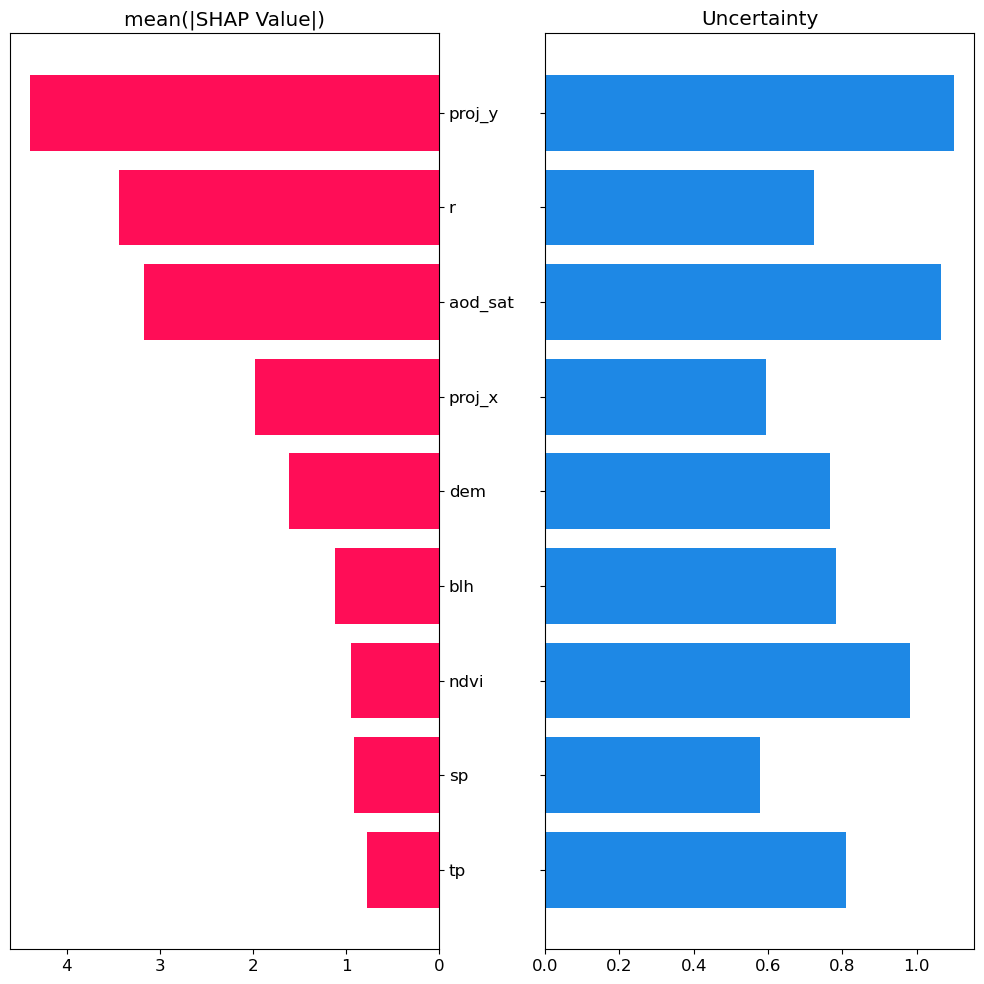

In [25]:
results.plot_absolute_shap_value_with_uncertainty()

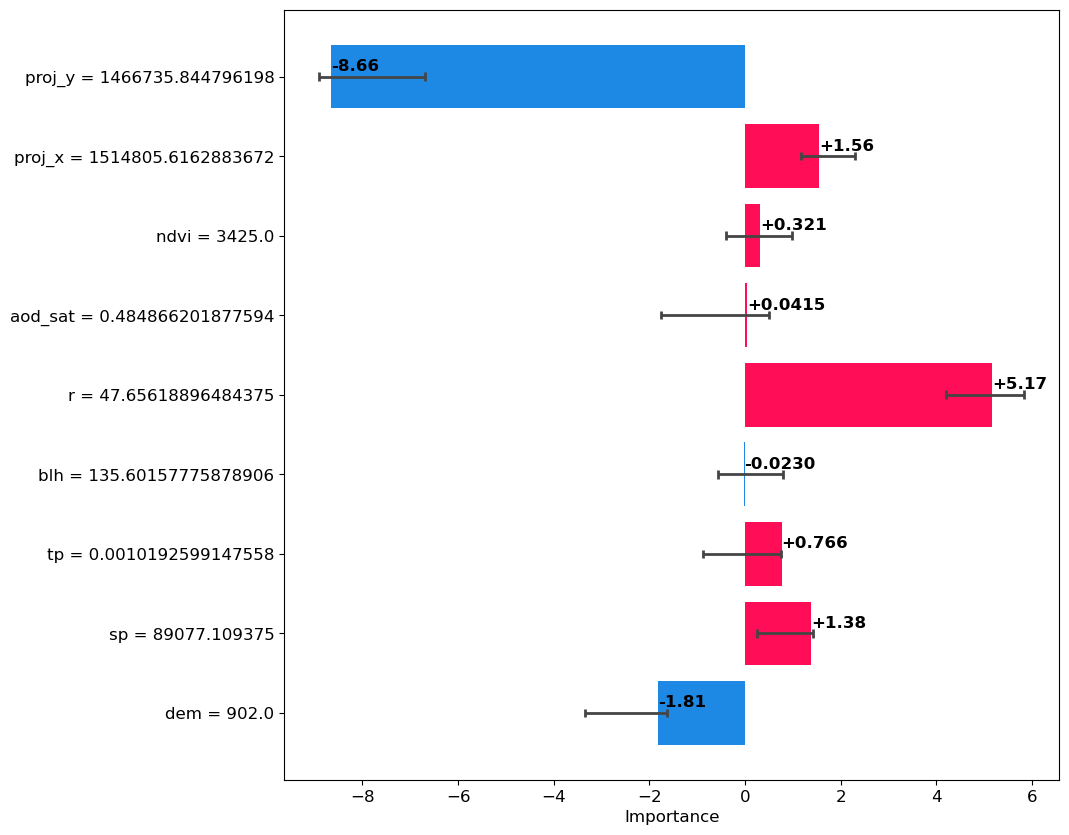

In [26]:
 results.plot_shap_values_with_uncertainty(10)

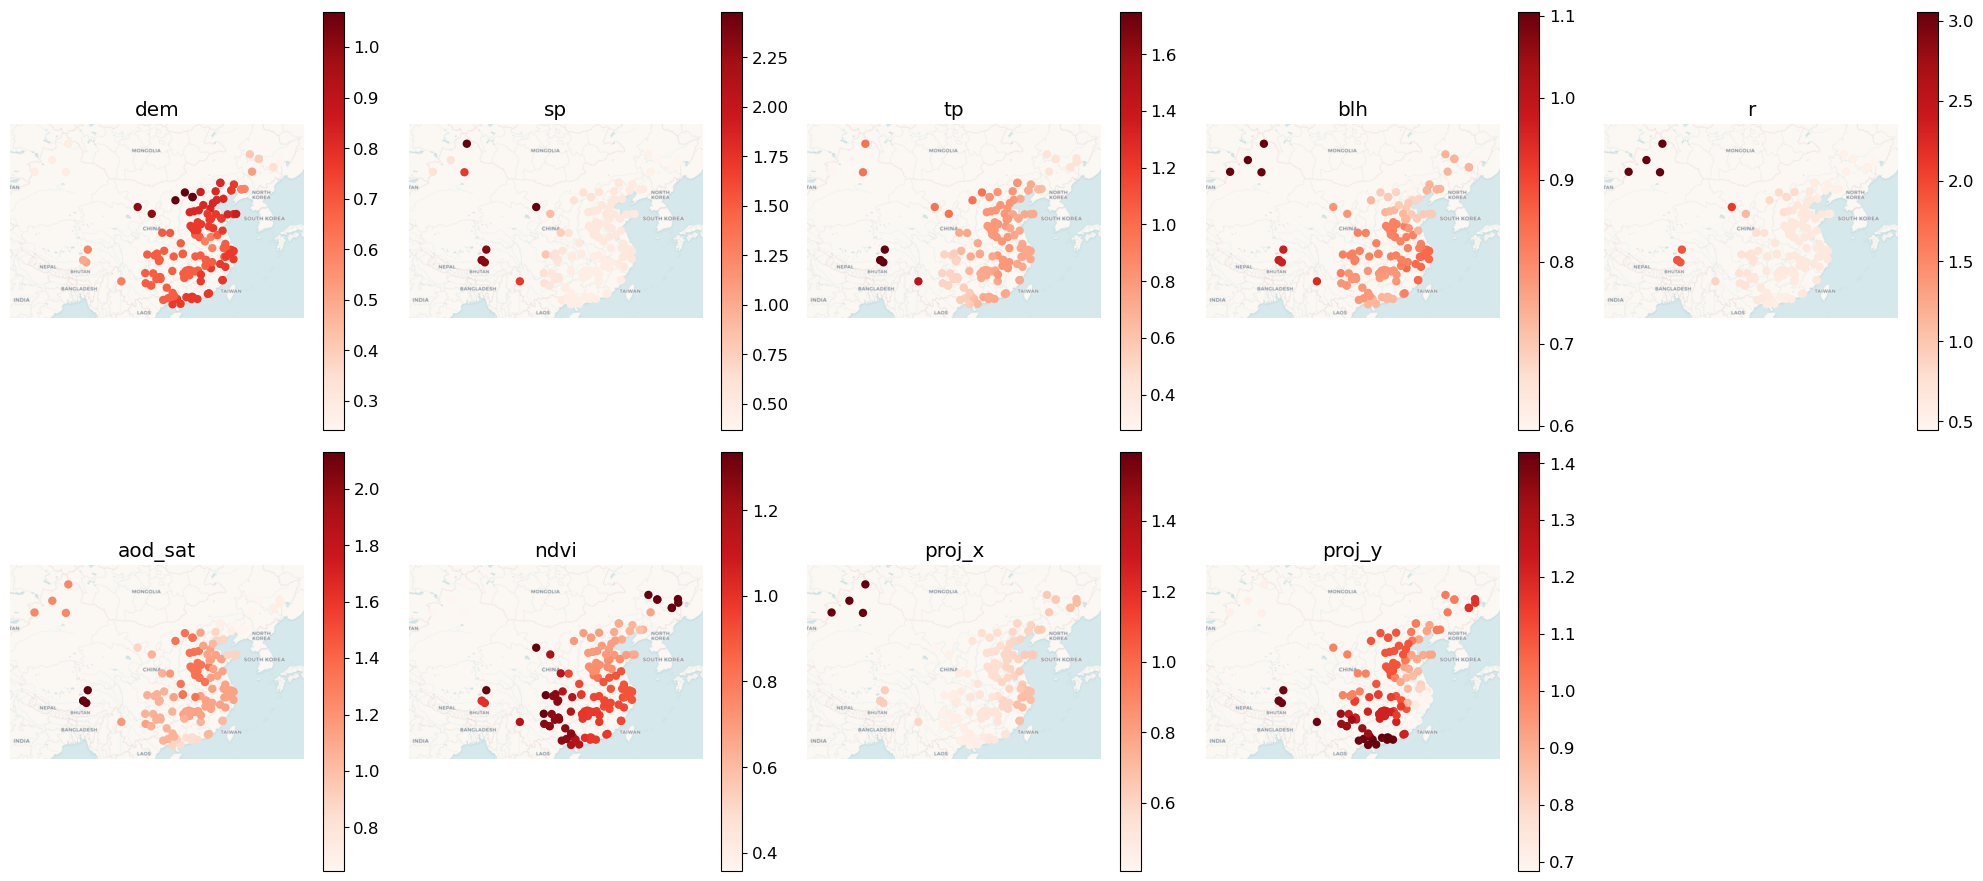

In [27]:
results.plot_geo_uncertainty(figsize=(20, 10), shrink=0.8)

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

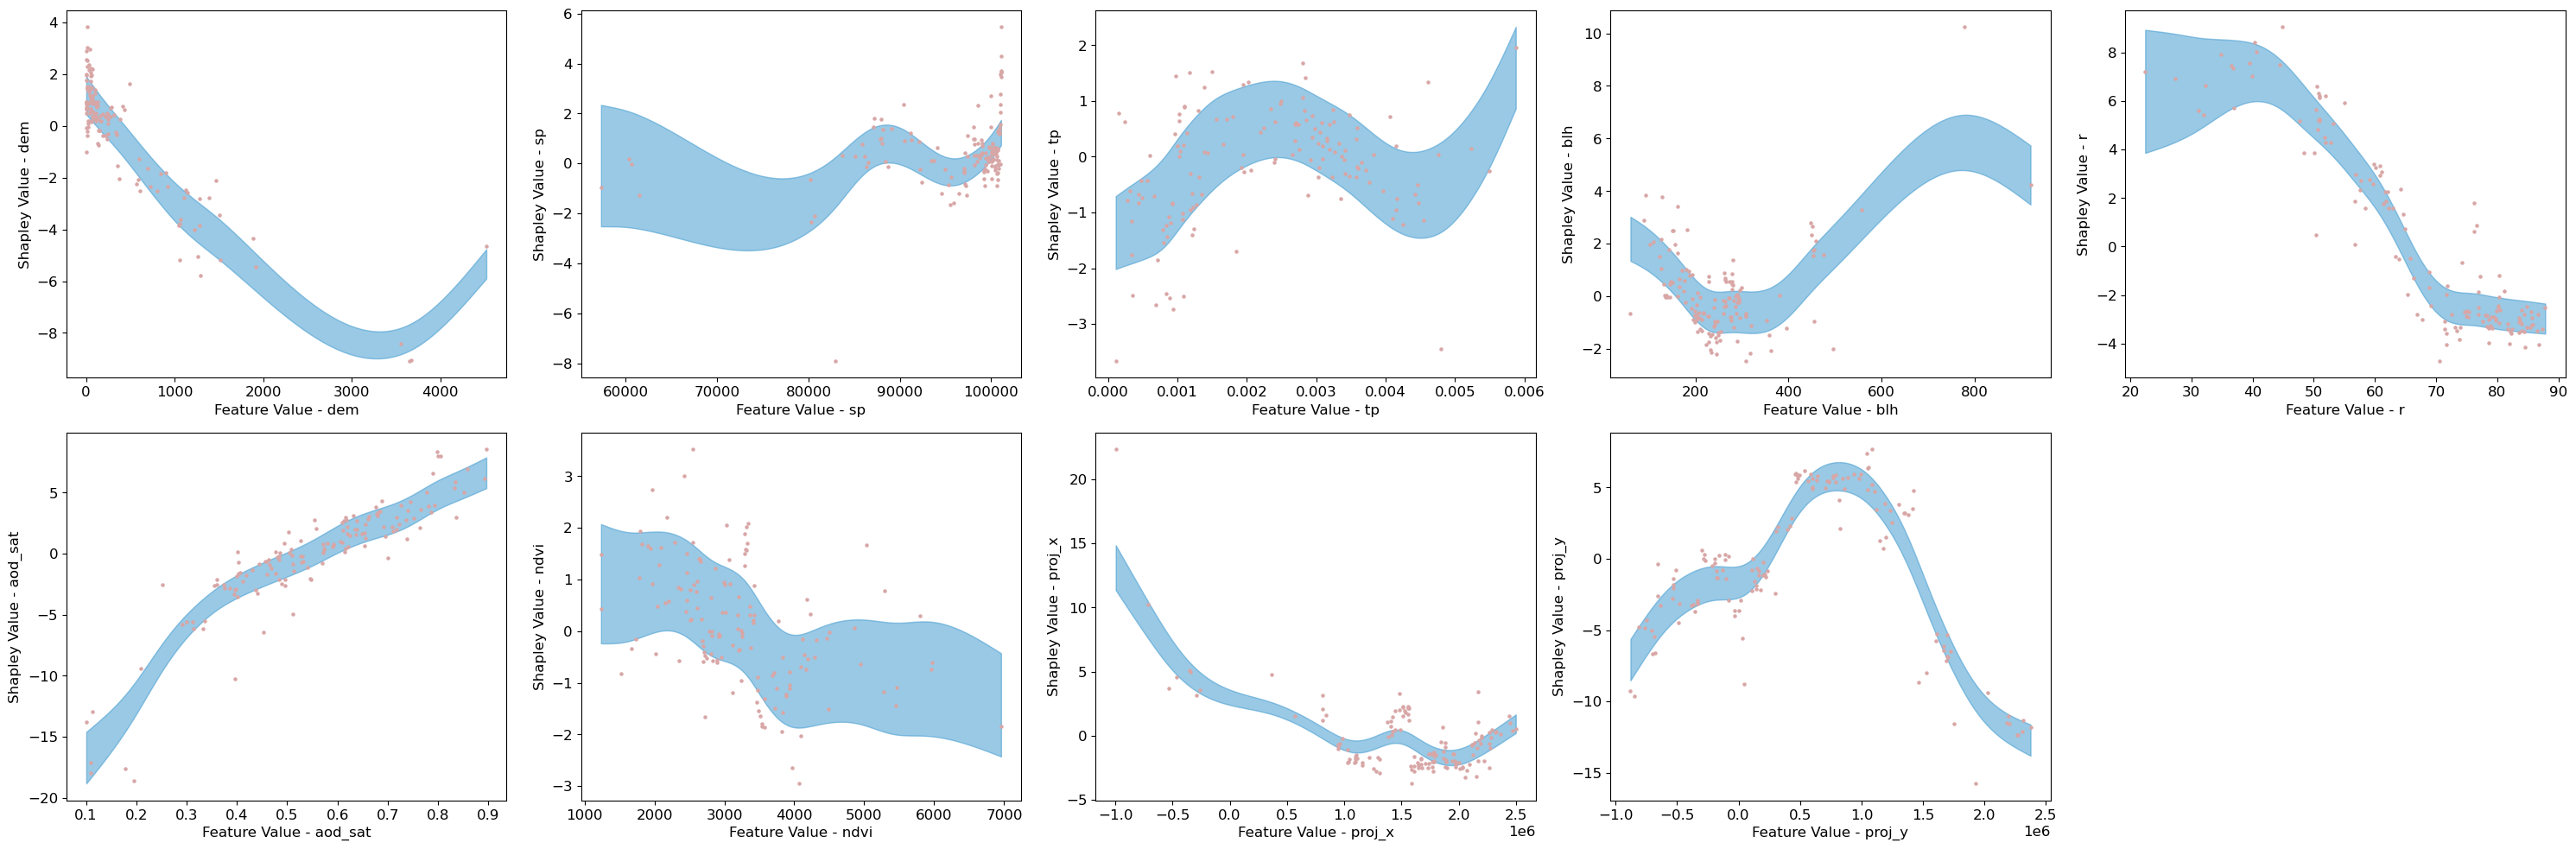

In [28]:
results.plot_partial_dependence_with_fitted_bounds()